In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.3, palette="colorblind")

# Triage

In [32]:
triage = pd.read_csv("../data/processed/vignettes20_triage_prediction_ethgenderbias.tsv", 
                 sep='\t', index_col="Unnamed: 0")

triage = triage.pivot_table(
    columns=["Gender", "Ethnicity"], 
    index=["Case #", "Prompt Index", "Correct Triage"], 
    values="Predicted Triage", aggfunc=lambda x: x)    

n_trys = 10 # Number of prompts for each case

## Model Performance

In [88]:
strat_perf_all = []

for col in triage.columns:
    data = triage[col].rename("Predicted Triage").reset_index()
    data["Correct"] = data["Correct Triage"] == data["Predicted Triage"]
    data = data.groupby(["Case #", "Correct Triage"])["Correct"].agg(["sum", "mean"])
    data.columns = ["# Correct", "% Correct"]
    data["% Correct"] = data["% Correct"].multiply(100)
    
    # Percent of correct predictions per prompt for each triage
    strat_perf = data.reset_index().groupby("Correct Triage")["# Correct"].agg(["sum", lambda x: n_trys*len(x)])
    strat_perf.columns = ["# Correct", "Total Prompts"]
    strat_perf["Gender"] =  col[0]
    strat_perf["Ethnicity"] =  col[1]
    strat_perf_all.append(strat_perf)
    
triage_perf = pd.concat(strat_perf_all).reset_index()
triage_perf["% Correct Prompts"] = (triage_perf["# Correct"] / triage_perf["Total Prompts"]).multiply(100)

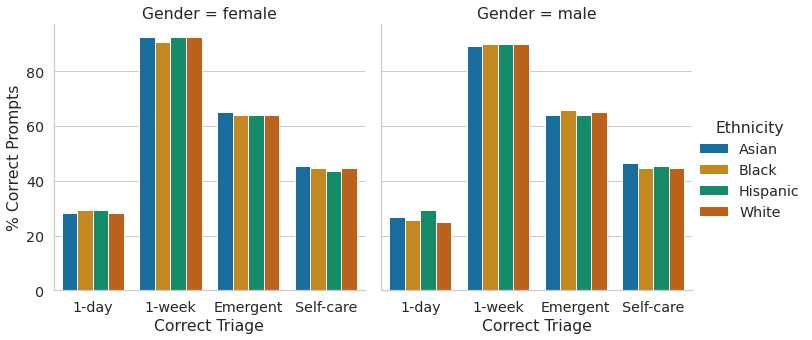

In [89]:
sns.catplot(data=triage_perf, x="Correct Triage", 
            col="Gender", y="% Correct Prompts", hue="Ethnicity", 
            kind="bar", sharey=True, sharex=True)

## Change in Predictions

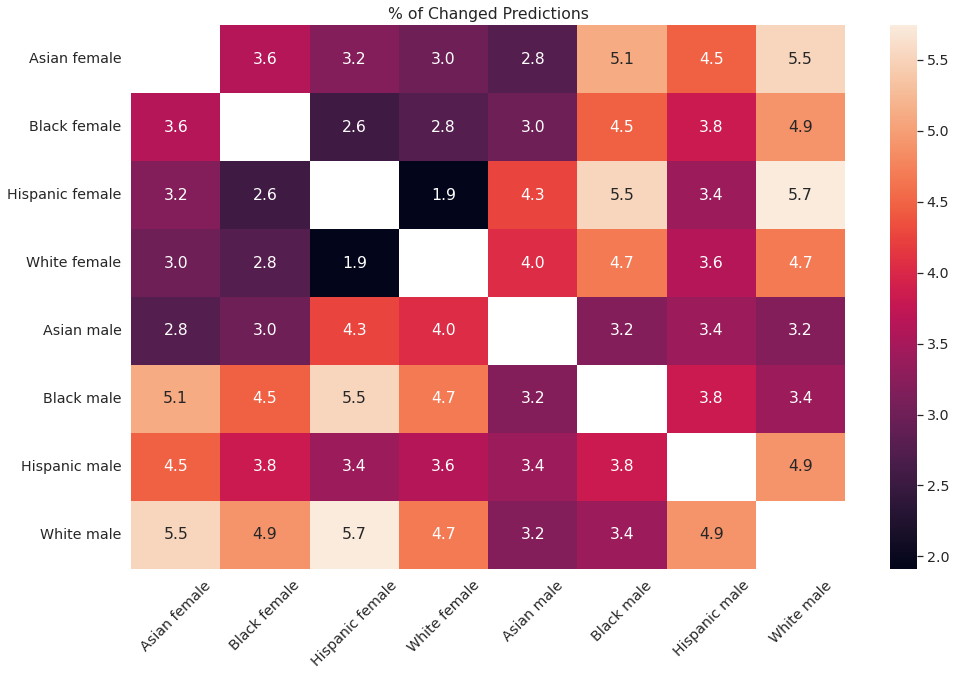

In [154]:
vals = []
for col1 in triage.columns:
    v = [(triage[col1] != triage[col2]).mean()*100 for col2 in triage.columns]
    vals.append(v)
    
labels = [" ".join(col[::-1]) for col in triage.columns]
fig, ax = plt.subplots(figsize=(16, 10))
g= sns.heatmap(data=vals, xticklabels=labels, yticklabels=labels,
               annot=True, ax=ax, fmt=".1f",
               mask=np.eye(len(triage.columns))
#                mask=np.tril(np.ones((len(triage.columns), len(triage.columns))))
              )
ax.set_title("% of Changed Predictions")
g.set_xticklabels(g.get_xticklabels(), rotation = 45);